Saved PCA features to pca_edge_features.csv
Original feature shape: (5712, 256)
Reduced feature shape: (5712, 10)


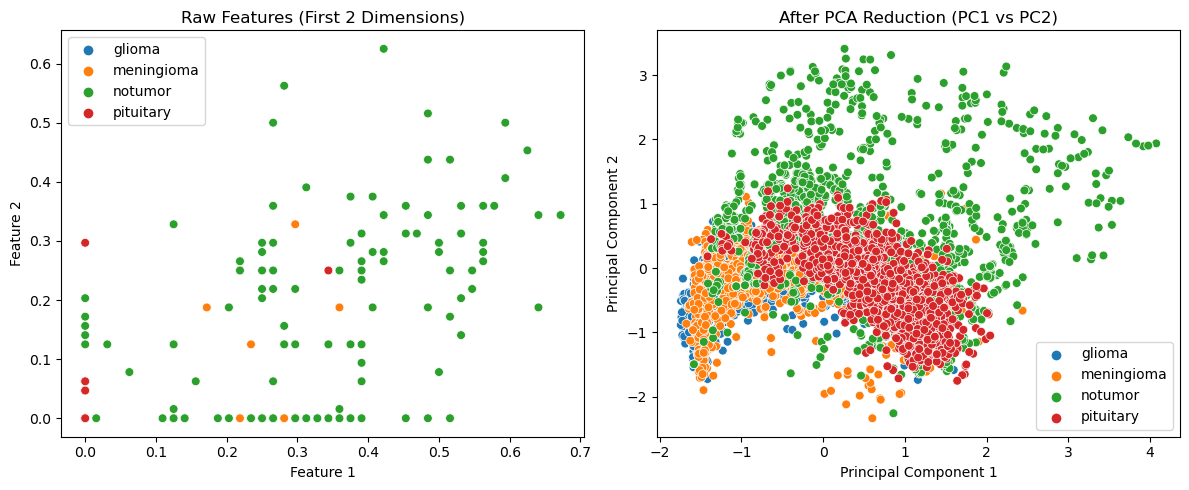

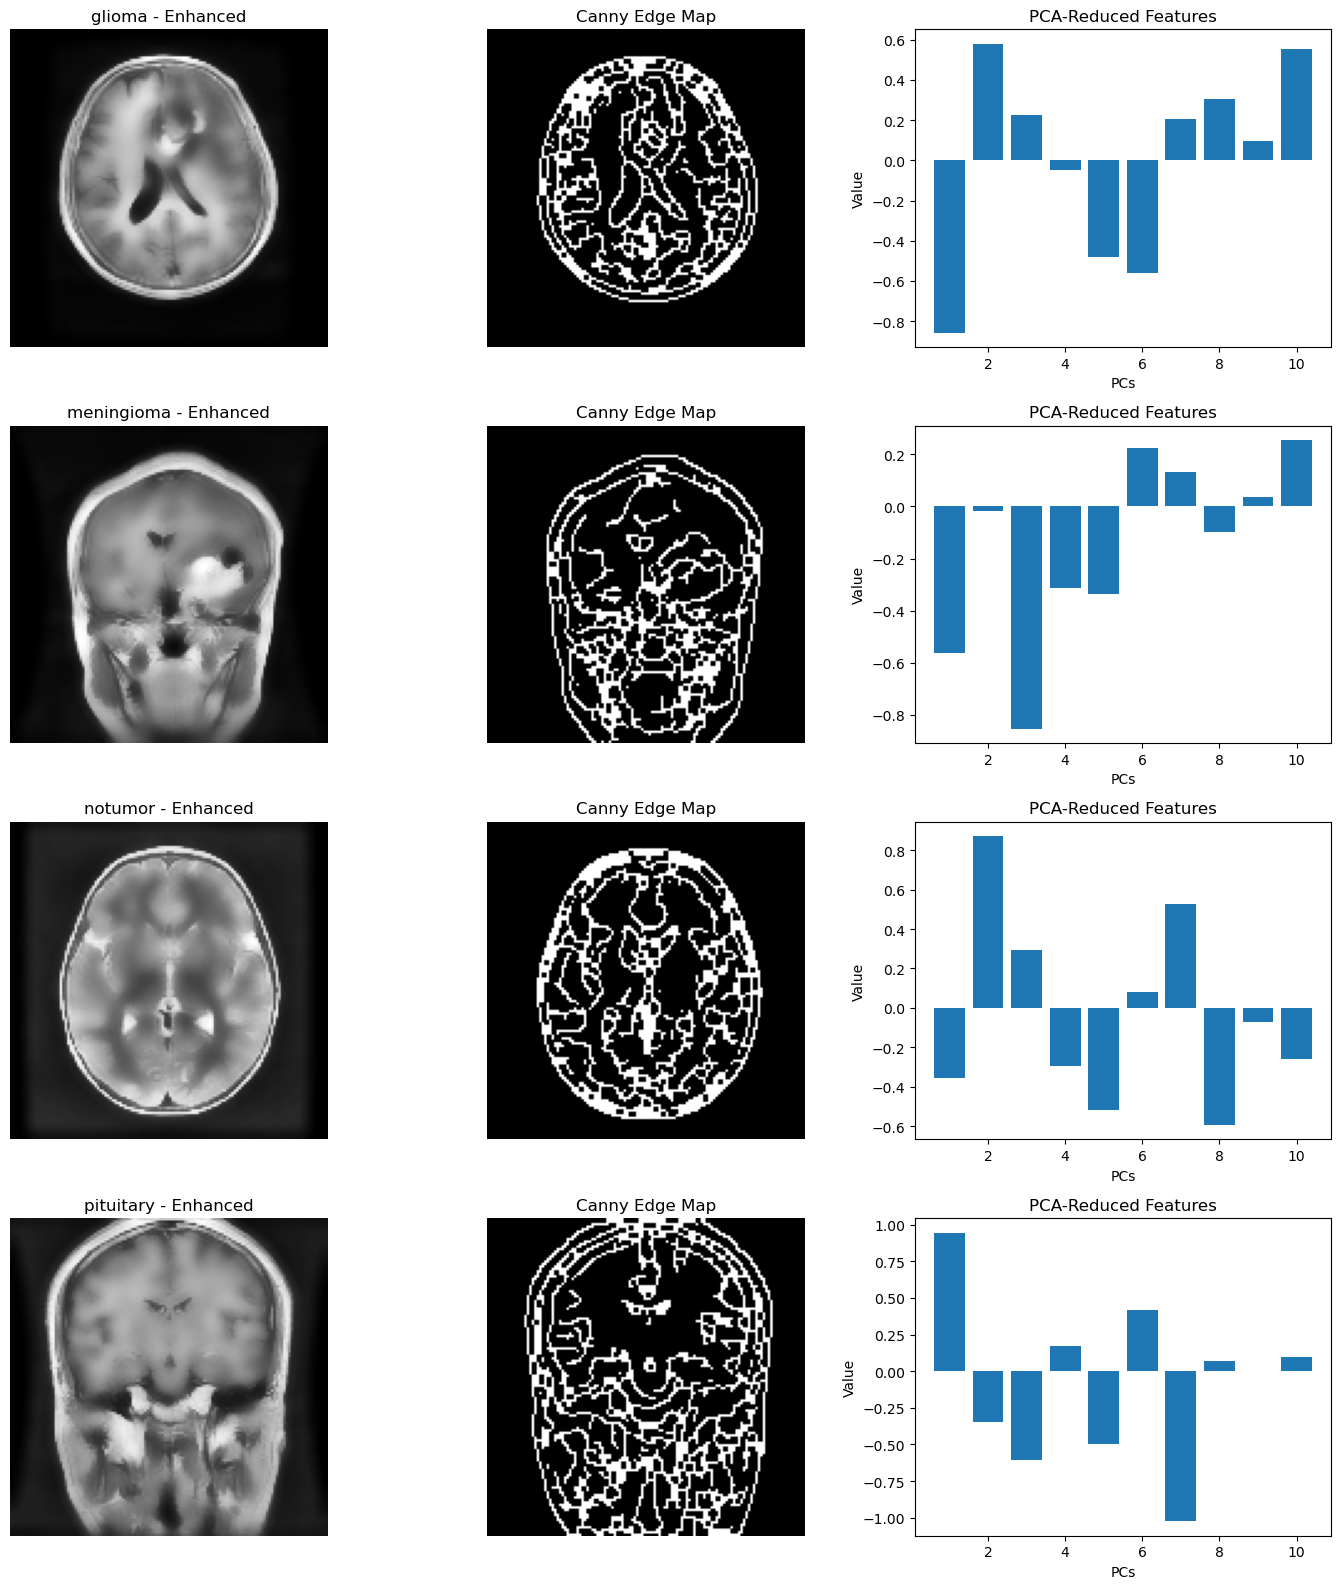

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from utils import preprocess_image

# =============================
# Feature extraction functions
# =============================

def enhance_and_denoise(path, im_size=(128, 128)):
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, im_size)

    # Contrast enhancement
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)

    # Denoising with edge preservation
    img_denoised = cv.bilateralFilter(img_clahe, d=9, sigmaColor=75, sigmaSpace=75)
    return img_denoised

def get_cleaned_canny(img):
    otsu_thresh_val, _ = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    low = int(0.5 * otsu_thresh_val)
    high = int(otsu_thresh_val)
    edges = cv.Canny(img.astype(np.uint8), low, high)

    # Cleanup
    kernel = np.ones((2, 2), np.uint8)
    edges_clean = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)
    return edges_clean

def blockwise_density(edges, block_size=(8, 8)):
    h, w = edges.shape
    bh, bw = block_size
    features = []
    for y in range(0, h, bh):
        for x in range(0, w, bw):
            block = edges[y:y+bh, x:x+bw]
            density = np.sum(block > 0) / (bh * bw)
            features.append(density)
    return np.array(features)

def extract_features_from_dataset(data_dir):
    features = []
    labels = []
    for label in sorted(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, label)
        if not os.path.isdir(class_dir):
            continue

        for fname in os.listdir(class_dir):
            if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            fpath = os.path.join(class_dir, fname)
            try:
                img = enhance_and_denoise(fpath)
                edges = get_cleaned_canny(img)
                fvec = blockwise_density(edges)
                features.append(fvec)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {fpath}: {e}")

    return np.array(features), np.array(labels)

# =============================
# Load dataset and apply PCA
# =============================
data_path = "data/Training"
X_raw, y_raw = extract_features_from_dataset(data_path)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y_raw)

# Apply PCA
n_components = min(10, X_raw.shape[1])
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_raw)

# Save PCA features
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df_pca["label"] = y_raw
df_pca.to_csv("pca_edge_features.csv", index=False)
print("Saved PCA features to pca_edge_features.csv")

# =============================
# Visualize Before vs. After PCA
# =============================
print(f"Original feature shape: {X_raw.shape}")
print(f"Reduced feature shape: {X_pca.shape}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_raw[:, 0], y=X_raw[:, 1], hue=y_raw, palette="tab10", s=40)
plt.title("Raw Features (First 2 Dimensions)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_raw, palette="tab10", s=40)
plt.title("After PCA Reduction (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

# =============================
# Visualize One Sample per Class
# =============================
def visualize_samples_per_class(data_dir, pca_model, classes):
    plt.figure(figsize=(14, len(classes) * 4))
    
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        img_name = os.listdir(class_dir)[0]  # Pick first image
        img_path = os.path.join(class_dir, img_name)

        # Process image
        img_enhanced = enhance_and_denoise(img_path)
        edges = get_cleaned_canny(img_enhanced)
        raw_features = blockwise_density(edges)
        reduced_features = pca_model.transform(raw_features.reshape(1, -1))[0]

        # Enhanced Image
        plt.subplot(len(classes), 3, idx * 3 + 1)
        plt.imshow(img_enhanced, cmap='gray')
        plt.title(f"{class_name} - Enhanced")
        plt.axis('off')

        # Canny Edge Map
        plt.subplot(len(classes), 3, idx * 3 + 2)
        plt.imshow(edges, cmap='gray')
        plt.title("Canny Edge Map")
        plt.axis('off')

        # PCA Feature Bar Plot
        plt.subplot(len(classes), 3, idx * 3 + 3)
        plt.bar(range(1, len(reduced_features) + 1), reduced_features)
        plt.title("PCA-Reduced Features")
        plt.xlabel("PCs")
        plt.ylabel("Value")

    plt.tight_layout()
    plt.show()

unique_classes = sorted(os.listdir(data_path))
visualize_samples_per_class(data_path, pca, unique_classes)
